If you are running this on Colab, please make sure to change your Runtime Type to GPU.

## Import required packages:


In [39]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import random
import shutil
from PIL import Image

## Install the latest version of BRAILS++:

In [2]:
pip install git+https://github.com/NHERI-SimCenter/BrailsPlusPlus

  Cloning https://github.com/NHERI-SimCenter/BrailsPlusPlus to /tmp/pip-req-build-0c1ycnbl
  Running command git clone --filter=blob:none --quiet https://github.com/NHERI-SimCenter/BrailsPlusPlus /tmp/pip-req-build-0c1ycnbl
  Resolved https://github.com/NHERI-SimCenter/BrailsPlusPlus to commit 7042dbbf68e1e81a8f438000c94d04fd3528d558
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nv

## Download PEER Hub ImageNet Φ-Net Data for Building Collapse Mode
For general info on the dataset please visit: https://apps.peer.berkeley.edu/phi-net/download/

The download link for the data: https://apps.peer.berkeley.edu/phichallenge/dataset/3ddwa5567



In [3]:
!wget -O data.zip https://apps.peer.berkeley.edu/phichallenge/dataset/3ddwa5567
!unzip data.zip

--2024-08-21 14:31:50--  https://apps.peer.berkeley.edu/phichallenge/dataset/3ddwa5567
Resolving apps.peer.berkeley.edu (apps.peer.berkeley.edu)... 128.32.143.25, 2607:f140:0:f::25
Connecting to apps.peer.berkeley.edu (apps.peer.berkeley.edu)|128.32.143.25|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://apps.peer.berkeley.edu/phichallenge/dataset/task5_collapse_mode.zip [following]
--2024-08-21 14:31:50--  https://apps.peer.berkeley.edu/phichallenge/dataset/task5_collapse_mode.zip
Reusing existing connection to apps.peer.berkeley.edu:443.
HTTP request sent, awaiting response... 200 OK
Length: 232967101 (222M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 222.17M   137MB/s    in 1.6s    

2024-08-21 14:31:52 (137 MB/s) - ‘data.zip’ saved [232967101/232967101]

Archive:  data.zip
   creating: task5/
  inflating: task5/task5_X_test.npy  
  inflating: task5/task5_y_test.npy  
  inflating: task5/task5_X_train.n

##Preprocess Φ-Net Data:
Φ-Net stores image data as a one big numpy array. These images are saved in BGR format and need to be normalized to convert into the correct RGB format.

BRAILS expects training data in the following format

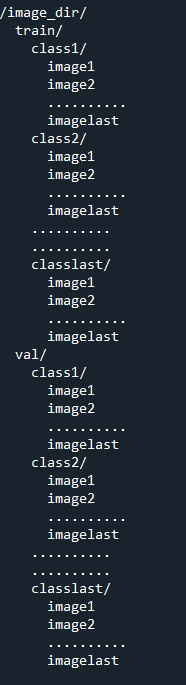

The following code parses the raw Φ-Net Data into this format.

In [4]:
datadir = 'task5/'            # Root directory the Numpy files are stored
classes = ['GC', 'NC', 'PC']  # Classes corresponding to the labels in the Numpy files
                              # GC: Global collapse, NC: No collapse, PC: Partial collapse

for phase in ['train', 'val']:
    for cl in classes:
        os.makedirs(datadir + f'data/{phase}/{cl}',exist_ok=True)
        os.makedirs(datadir + f'data/{phase}/{cl}',exist_ok=True)
    if phase=='val':
        phasew = 'test'
    else:
        phasew = 'train'
    ims = np.load(datadir + f'task5_X_{phasew}.npy')
    maxpix = np.amax(ims)
    minpix = np.amin(ims)
    labels = np.load(datadir + f'task5_y_{phasew}.npy')
    labels[:,1]*=2
    labels[:,2]*=3
    labels = (labels[np.where(labels!=0)] - 1).astype(int)
    for im in range(0,len(ims)):
            img = ((ims[im,:,:,:]) - minpix)*255/(maxpix - minpix)
            cl = classes[labels[im]]
            cv2.imwrite(datadir + f'data/{phase}/{cl}/{im}.jpg', img)

## Call BRAILS ImageClassifier to train a classifier model:

**ImageClassifier()** initiates the classifier model class object with a classifer architecture. Available architectures are ResNet (50, 101, 152), EfficientNet_v2 (small, medium, large), ConvNext (small, base, large), RegNet (16, 32), and Vision Transformer (ViT-H14, ViT-B16)

**ImageClassifier.train(model_arch = 'efficientnetv2_s', train_data_dir = 'tmp/hymenoptera_data', batch_size = 32, nepochs = 100, es_tolerance = 10, plot_accuracy = True)** trains a classifier model using transfer learning.

**ImageClassifier.retrain(model_arch = 'efficientnetv2_s', model_path='tmp/models/trained_model.pth',train_data_dir = 'tmp/hymenoptera_data', batch_size = 32, nepochs = 100, es_tolerance = 10, plot_accuracy = True)** retrains a model using specified training dataset and hyperparameters. The defined model in modelPath and the training data in trainDataDir must be compatible to use this method.

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 185MB/s]


Epoch 0/9
----------
Train Loss: 0.7330 Acc: 0.6892
Val Loss: 2.0569 Acc: 0.5205

Epoch 1/9
----------
Train Loss: 0.6040 Acc: 0.7357
Val Loss: 1.0569 Acc: 0.4932

Epoch 2/9
----------
Train Loss: 0.5266 Acc: 0.7798
Val Loss: 0.7910 Acc: 0.6849

Epoch 3/9
----------
Train Loss: 0.4872 Acc: 0.8067
Val Loss: 0.9103 Acc: 0.5479

Epoch 4/9
----------
Train Loss: 0.4439 Acc: 0.8320
Val Loss: 1.1384 Acc: 0.6233

Epoch 5/9
----------
Train Loss: 0.3790 Acc: 0.8426
Val Loss: 1.1488 Acc: 0.5685

Epoch 6/9
----------
Train Loss: 0.3588 Acc: 0.8540
Val Loss: 0.9727 Acc: 0.6370

Epoch 7/9
----------
Train Loss: 0.3119 Acc: 0.8858
Val Loss: 0.9584 Acc: 0.7329

Epoch 8/9
----------
Train Loss: 0.2735 Acc: 0.8956
Val Loss: 0.8717 Acc: 0.7055

Epoch 9/9
----------
Train Loss: 0.2050 Acc: 0.9233
Val Loss: 1.4196 Acc: 0.5685

Best val Acc: 0.732877
Elapsed time: 7m 16s
New classifier head trained using transfer learning.

Fine-tuning the model...
Epoch 0/9
----------
Train Loss: 0.1747 Acc: 0.9372
Val L

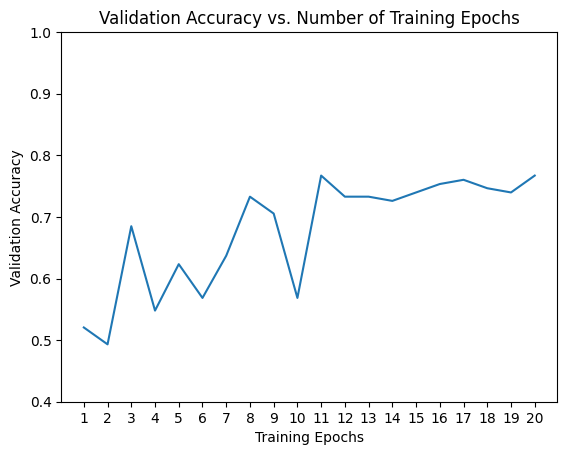

In [5]:
from brails.utils import Importer
importer = Importer()
myclass = importer.get_class('ImageClassifier')
imclassifier = myclass()
imclassifier.train(train_data_dir='task5/data', nepochs=20)

## Plot the change in validation accuracy over training epochs:

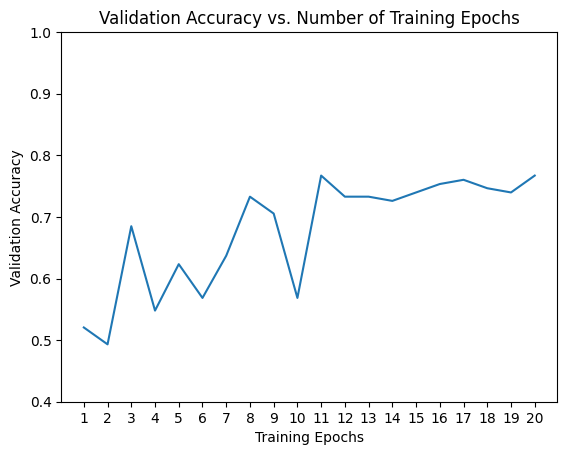

In [6]:
%matplotlib inline
nepochs_print = len(imclassifier.accuracy)+1
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1, nepochs_print), imclassifier.accuracy)
plt.ylim((0.4,1.))
plt.xticks(np.arange(1, nepochs_print, 1.0))
plt.show()

## Randomly select a number of samples from each class to see how well we predict:
**predict(images, model_arch='efficientnetv2_s',
  model_path='tmp/models/trained_model.pth',
                classes=['Ants','Bees'])** loads the model in model_path and uses this model to predict the classes for the image data in images using the labels listed in classes.

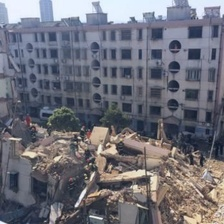

Predicted class: GC
Actual class: GC


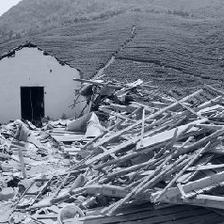

Predicted class: GC
Actual class: GC


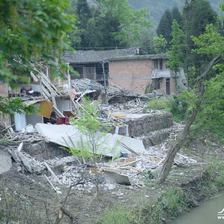

Predicted class: GC
Actual class: GC


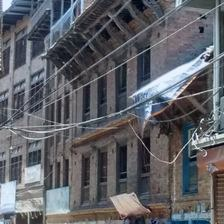

Predicted class: NC
Actual class: NC


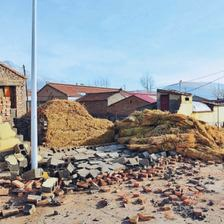

Predicted class: GC
Actual class: NC


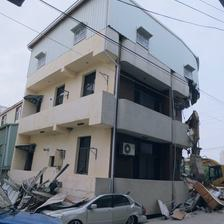

Predicted class: NC
Actual class: NC


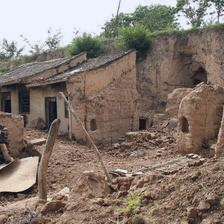

Predicted class: PC
Actual class: PC


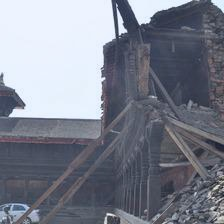

Predicted class: PC
Actual class: PC


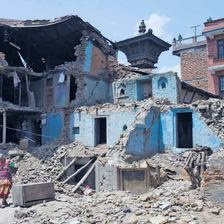

Predicted class: PC
Actual class: PC


In [41]:
from brails.types.image_set import ImageSet

nsamples = 3
for cl in  classes:
    images = ImageSet()
    imdir = datadir + f'data/val/{cl}'
    images.set_directory(imdir,True)
    samples = random.sample(list(images.images),nsamples)
    preds = imclassifier.predict(images, classes=classes)
    for sample in samples:
        image = Image.open(imdir + '/' + images.images[sample].filename)
        display(image)
        print(f'Predicted class: {preds[sample]}')
        print(f'Actual class: {cl}')

## View the number of training samples for each class:

In [13]:
im = os.listdir('task5/data/train/GC')
print(f'GC: {len(im)}')
im = os.listdir('task5/data/train/NC')
print(f'NC: {len(im)}')
im = os.listdir('task5/data/train/PC')
print(f'PC: {len(im)}')

GC: 525
NC: 322
PC: 379


## Create a balanced training dataset from the original set:

In [14]:
nsamples = 322
for cl in classes:
    dir = f'task5/data_reduced/train/{cl}'
    os.makedirs(dir,exist_ok=True)
    ims = os.listdir(f'task5/data/train/{cl}')
    ims_red = random.sample(ims,nsamples)
    for im in ims_red:
      shutil.copyfile(f'task5/data/train/{cl}/{im}', f'task5/data_reduced/train/{cl}/{im}')
shutil.copytree('task5/data/val','task5/data_reduced/val')

'task5/data_reduced/val'

## View the number of training samples for each class in the balanced set:

In [15]:
im = os.listdir('task5/data_reduced/train/GC')
print(f'GC: {len(im)}')
im = os.listdir('task5/data_reduced/train/NC')
print(f'NC: {len(im)}')
im = os.listdir('task5/data_reduced/train/PC')
print(f'PC: {len(im)}')

GC: 322
NC: 322
PC: 322


## Further train the previous model using the balanced dataset:


Retraining the model using the data located in task5/data_reduced folder...
Epoch 0/9
----------
Train Loss: 0.1610 Acc: 0.9389
Val Loss: 1.0177 Acc: 0.7466

Epoch 1/9
----------
Train Loss: 0.1340 Acc: 0.9596
Val Loss: 0.9659 Acc: 0.7466

Epoch 2/9
----------
Train Loss: 0.1302 Acc: 0.9555
Val Loss: 0.9472 Acc: 0.7534

Epoch 3/9
----------
Train Loss: 0.1166 Acc: 0.9576
Val Loss: 0.9814 Acc: 0.7397

Epoch 4/9
----------
Train Loss: 0.1172 Acc: 0.9627
Val Loss: 0.9480 Acc: 0.7466

Epoch 5/9
----------
Train Loss: 0.1234 Acc: 0.9513
Val Loss: 0.9128 Acc: 0.7740

Epoch 6/9
----------
Train Loss: 0.1133 Acc: 0.9627
Val Loss: 0.9312 Acc: 0.7534

Epoch 7/9
----------
Train Loss: 0.1075 Acc: 0.9648
Val Loss: 0.9726 Acc: 0.7397

Epoch 8/9
----------
Train Loss: 0.1026 Acc: 0.9700
Val Loss: 0.9648 Acc: 0.7466

Epoch 9/9
----------
Train Loss: 0.1015 Acc: 0.9720
Val Loss: 0.9566 Acc: 0.7466

Best val Acc: 0.773973
Elapsed time: 6m 7s
Training complete.


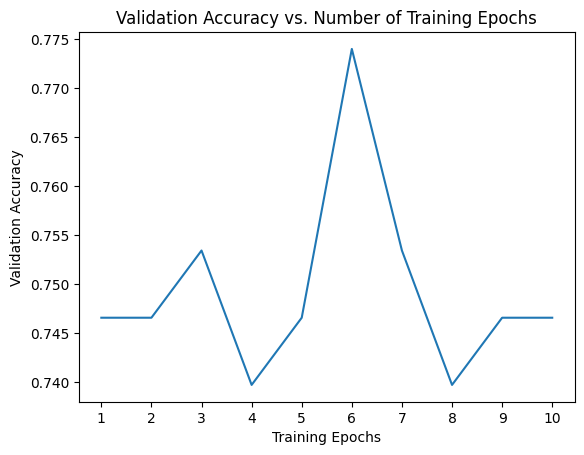

In [18]:
imclassifier.retrain(train_data_dir='task5/data_reduced',nepochs=10)